# SIR model

In the agent-based modeling approach an epidemiological model, like SIR model can have a large number of parameters depending upon the requirements. Below we will implement a basic SIR model in EasyABM.

In [1]:
using Pkg, Revise
Pkg.activate(joinpath(@__DIR__, "../.."))
using EasyABM

  Activating project at `~/Documents/EasyABM`


WebIO._IJuliaInit()

## Step 1: Create Agents and Model

In our SIR model there will be four type of agents - susceptible, infectious, recovered, dead. We assume that the recovered agents become immune and do not get infected again. We create 500 2d agents all of type agentS (later in the initilisation step will set the type of some agents to be agentI). The `not_well_since` property of an agent is the time since the agent got infected. Our model has parameters `initially_sick` (number of agents initially sick), `sickness_duration` (duration of sickness), `infection_prob` (probability of infection when an infected agent comes in contact with a susceptible agent) and `death_prob` (the probability of death from infection). 

In [5]:
@enum agentstate begin
    susceptible=1
    infectious=2
    recovered=3
    dead=4
end

In [6]:
agents = grid_2d_agents(500, pos = Vect(1,1), color=cl"green", 
        atype = susceptible, not_well_since = 0, 
        keeps_record_of = Set([:atype, :color, :pos]));

model = create_2d_model(agents, size=(50,50), 
        agents_type = Static, # agents don't get removed from or added to model
        space_type = Periodic, initially_sick = 10, 
        sickness_duration = 21, infection_prob = 0.8, 
        death_prob=0.05);

## Step 2: Initialise the model

In the second step we initialise the agents by defining `initialiser!` function and sending it as an argument to `init_model!`. In the `initialiser!` function we set first `initially_sick` number of agents to be in infectious state and set their color to `cl"red"`. All other agents are set to be in susceptible state with color `cl"green"`. We also set each agents position at the center of a randomly selected patch. 


In [7]:
function initialiser!(model)
    for (i,agent) in enumerate(model.agents)
        if i<=model.parameters.initially_sick
            agent.atype = infectious
            agent.color = cl"red"
        else 
            agent.atype = susceptible
            agent.color = cl"green"
        end
        agent.not_well_since = 0 
        x = rand(1:model.size[1])
        y = rand(1:model.size[2])
        agent.pos = Vect(x, y) # center of a random patch
    end
end
init_model!(model, initialiser = initialiser!)

## Step 3: Run the model

In this step we implement the step logic of the SIR model in the `step_rule!` function and run the model for 100 steps.

In [8]:
function die_or_recover(agent, death_prob)
    if rand()<death_prob
        agent.atype = dead
        agent.color = cl"black"
    else
        agent.atype = recovered
        agent.color = cl"yellow"
    end
    agent.not_well_since = 0 
end

function infect_neighbors(agent, nbrs, infection_prob)
    for nbr in nbrs
        if (nbr.atype ==susceptible) && (rand()< infection_prob)
            nbr.atype = infectious
            nbr.not_well_since = 0
            nbr.color = cl"red"
        end
    end
end

function change_position(agent)
    dx =rand(-1:1)
    dy =rand(-1:1)
    agent.pos += Vect(dx,dy)
end

function step_rule!(model)
    parameters = model.parameters
    for agent in model.agents
        nbrs = grid_neighbors(agent, model, 1) #immediate neighbors on grid
        if agent.atype == infectious
             agent.not_well_since +=1
            if agent.not_well_since > parameters.sickness_duration
                die_or_recover(agent, parameters.death_prob)
            elseif agent.not_well_since>1
                infect_neighbors(agent, nbrs, parameters.infection_prob)
            end   
        end
        if agent.atype !=dead
            change_position(agent)
        end   
    end
end

step_rule! (generic function with 1 method)

In [9]:
run_model!(model, steps = 100, step_rule = step_rule! )

## Step 4: Visualisation

In order to draw the model at a specific frame, say 4th, one can use

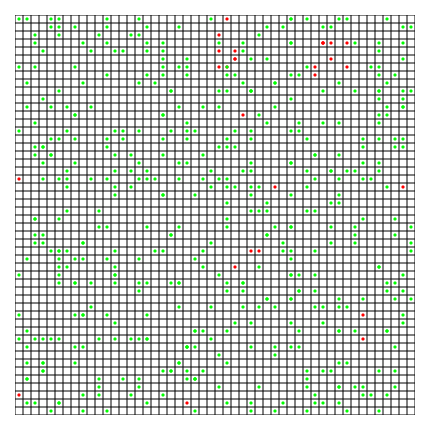

In [10]:
draw_frame(model, frame =4, show_grid=true)

If one wants to see the animation of the model run, it can be done as 

In [12]:
animate_sim(model, 
agent_plots = Dict(
        "Susceptible"=> ag -> ag.atype == susceptible ? 1 : 0, 
        "Infected" => ag -> ag.atype == infectious ? 1 : 0,
        "Recovered" => ag -> ag.atype == recovered ? 1 : 0
        ),
show_grid=true
)

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 101, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(51), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fda1caa8010, Task (runnable) @0x00007fda1caa8010), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 0)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n 

After defining the `step_rule!` function we can also choose to create an interactive application (which currently works in Jupyter with WebIO installation) as 

In [17]:
create_interactive_app(model, initialiser= initialiser!,
    step_rule= step_rule!,
    model_controls=[(:initially_sick, "slider", 1:500), 
        (:sickness_duration, "slider", 5:25),
        (:infection_prob, "slider", 0.01:0.01:1.0),
        (:death_prob, "slider", 0.01:0.01:0.1)
        ],
    agent_plots = Dict("Susceptible"=> ag -> ag.atype == susceptible ? 1 : 0, 
        "Infected" => ag -> ag.atype == infectious ? 1 : 0,
        "Recovered" => ag -> ag.atype == recovered ? 1 : 0
        ),
    frames=70,
    show_grid=true) 

WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Scope(WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 70, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable(0), nothing), "index" => (Observable(1), nothing)), Set{String}(), nothing, WebIO.Asset[WebIO.Asset("js", "knockout", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout.js"), WebIO.Asset("js", "knockout_punches", "/home/dushya/.julia/packages/Knockout/HReiN/src/../assets/knockout_punches.js"), WebIO.Asset("js", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/all.js"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/InteractBase/LJXv3/src/../assets/style.css"), WebIO.Asset("css", nothing, "/home/dushya/.julia/packages/Interact/PENUy/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{WebIO.AbstractConnection}(), Base.GenericCondition{ReentrantLock}(Base.IntrusiveLinkedList{Task}(Task (runnable) @0x00007fda2dba9460, Task (runnable) @0x00007fda2dba9460), ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 0, 1)))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n   

## Step 4: Fetch Data 

The following line of code fetches data of average number of susceptible, infectious and recovered agents. 
The function `get_agents_avg_props` averages over all agents the values returned by functions sent to it as arguments. 

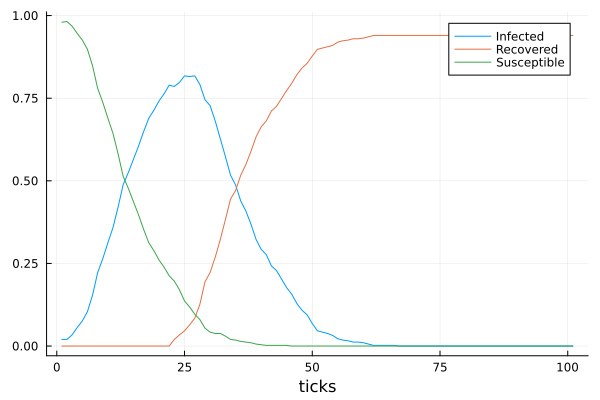

Row,Infected,Recovered,Susceptible
,Float64,Float64,Float64
1,0.02,0.0,0.98
2,0.02004,0.0,0.98196
3,0.0340401,0.0,0.967964
4,0.0560681,0.0,0.945936
5,0.0761121,0.0,0.925892
6,0.104152,0.0,0.897852
7,0.154208,0.0,0.847796
8,0.222308,0.0,0.779696
9,0.264445,0.0,0.737559


In [13]:
df = get_agents_avg_props(model, 
    ag -> ag.atype == susceptible ? 1 : 0,
    ag -> ag.atype == infectious ? 1 : 0, 
    ag -> ag.atype == recovered ? 1 : 0, 
    labels = ["Susceptible", "Infected", "Recovered"],
    plot_result = true
)